In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from surprise import SVD, Dataset, Reader
from sklearn.metrics import mean_squared_error
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
warnings.filterwarnings('ignore')

In [3]:
# Load dataset
data = pd.read_csv("data/Tempat-Wisata-Toba-Preprocessing.csv")
# print sample data
data.head()

,Unnamed: 0.1,Unnamed: 0,address,PlaceID,Nama_tempat_wisata,Category,ReviewerId,Rating,Reviews
0,0,0,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",0,PASIR PUTIH LUMBAN BULBUL,Wisata Bahari,1.126030e+20,5.0,NaN
1,1,1,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",0,PASIR PUTIH LUMBAN BULBUL,Wisata Bahari,1.119090e+20,5.0,bagus
2,2,2,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",0,PASIR PUTIH LUMBAN BULBUL,Wisata Bahari,1.078860e+20,5.0,NaN
3,3,3,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",0,PASIR PUTIH LUMBAN BULBUL,Wisata Bahari,1.130720e+20,5.0,sangat menyenagkan
4,4,4,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",0,PASIR PUTIH LUMBAN BULBUL,Wisata Bahari,1.061730e+20,5.0,bebas foto dimana aja cuma 2k


### Preprocessing Dataset

In [4]:
# preprocess_data
from sklearn.preprocessing import MinMaxScaler

def preprocess_data(data):
    # Drop missing values (alternatif: imputasi)
    data = data.dropna()
    
    # Drop kolom tidak relevan
    data = data.drop(["Unnamed: 0", "Unnamed: 0.1"], axis=1)
    
    # Normalize rating
    scaler = MinMaxScaler()
    data["NormalRating"] = scaler.fit_transform(data[["Rating"]])
    
    # Encode ID
    le_user = LabelEncoder()
    le_place = LabelEncoder()
    data["ReviewerId"] = le_user.fit_transform(data["ReviewerId"])
    data["PlaceID"] = le_place.fit_transform(data["PlaceID"])
    
    # Split data
    train, test = train_test_split(data, test_size=0.3, random_state=42)
    test, val = train_test_split(test, test_size=0.5, random_state=42)
    
    return train, test, val, le_user, le_place




### Collaborative filtering

In [5]:
# collaborative_filtering
def collaborative_filtering(train):
    # Load data
    reader = Reader(rating_scale=(0, 1))
    data_surprise = Dataset.load_from_df(
        train[["ReviewerId", "PlaceID", "NormalRating"]], reader
    )
    trainset = data_surprise.build_full_trainset()

    # Train SVD
    svd = SVD()
    svd.fit(trainset)

    return svd


### Content based filtering

In [6]:
# content_based_filtering
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

def content_based_filtering(train):
    # Load data
    factory = StopWordRemoverFactory()
    stopwords = factory.get_stop_words()
    tfidf = TfidfVectorizer(stop_words=stopwords)
    tfidf_matrix = tfidf.fit_transform(train["Reviews"])
    
    # Calculate cosine similarity
    cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
    
    return cosine_sim, tfidf



### Hybrid Filtering

In [7]:
# Hybrid filtering
def hybrid_recommendation(predictions, cosine_sim, svd, val):
    # Predict rating
    val["PredictedRating"] = val.apply(
        lambda x: svd.predict(x["ReviewerId"], x["PlaceID"]).est, axis=1
    )
    
    # Hybrid score: Combine Collaborative and Content-Based Filtering
    hybrid_scores = []
    for i, row in val.iterrows():
        cb_score = cosine_sim[row["PlaceID"]].mean()  # Content-based score
        cf_score = row["PredictedRating"]  # Collaborative score
        hybrid_scores.append(0.5 * cb_score + 0.5 * cf_score)
    
    val["HybridScore"] = hybrid_scores
    return val



### Evaluasi Model

#### Rating-Based Metrics

In [8]:
# evaluasi rating based metrics
def evaluate_ranking_based(val):
    from sklearn.metrics import precision_score, recall_score
    # Thresholding
    val["Relevant"] = val["NormalRating"] >= 0.5
    val["Recommended"] = val["HybridScore"] >= 0.5
    
    # Precision and Recall
    precision = precision_score(val["Relevant"], val["Recommended"])
    recall = recall_score(val["Relevant"], val["Recommended"])
    
    # MAP
    val = val.sort_values("HybridScore", ascending=False)
    val["Rank"] = range(1, len(val) + 1)
    val["CumulativeRelevant"] = val["Relevant"].cumsum()
    val["PrecisionAtK"] = val["CumulativeRelevant"] / val["Rank"]
    map_score = val.loc[val["Relevant"], "PrecisionAtK"].mean()
    
    return precision, recall, map_score



#### Ranking-Based Metrics

In [9]:
# Fungsi untuk menghitung RMSE dan MAE
def evaluate_rating_based(val):
    rmse = np.sqrt(mean_squared_error(val["NormalRating"], val["PredictedRating"]))
    mae = mean_absolute_error(val["NormalRating"], val["PredictedRating"])
    return rmse, mae

### Penggunaan

In [10]:
# 1. Preprocessing Data
train, test, val, le_user, le_place = preprocess_data(data)

# 2. Collaborative Filtering
svd = collaborative_filtering(train)

# 3. Content-Based Filtering
cosine_sim, tfidf = content_based_filtering(train)

# 4. Hybrid Filtering
val = hybrid_recommendation(val, cosine_sim, svd, val)

# 5. Evaluasi
precision, recall, map_score = evaluate_ranking_based(val)
rmse, mae = evaluate_rating_based(val)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"MAP: {map_score}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")




Precision: 0.9928571428571429
Recall: 0.0433832709113608
MAP: 0.9748039198121355
RMSE: 0.21534626675461466
MAE: 0.15826464671960722


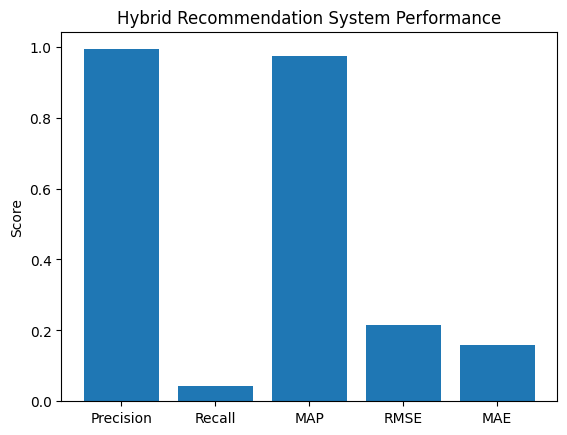

In [12]:
# visualisasi hasil evaluasi dengan bar chart
import matplotlib.pyplot as plt

metrics = ["Precision", "Recall", "MAP", "RMSE", "MAE"]
values = [precision, recall, map_score, rmse, mae]

plt.bar(metrics, values)
plt.ylabel("Score")
plt.title("Hybrid Recommendation System Performance")
plt.show()

